# 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os 
import glob
import cv2
import itertools

from dataloader_distance import *

# Linear Regression : Only Distance
- 속도가 높을수록 변동이 심함
- 10.01 -> 12.42 -> 21.66

## 3km

In [2]:
file_path_train = "D:\gait_dataset/salted/3km/train/*"
_, _, y_train = get_sensor_salted(file_path_train)
inputs_pst_train = get_position_salted(file_path_train, distance=True)

file_path_test = "D:\gait_dataset/salted/3km/test/*"
_, _, y_test = get_sensor_salted(file_path_test)
inputs_pst_test = get_position_salted(file_path_test, distance=True)

In [8]:
x_train

,R_DIS_X,R_DIS_Y,R_DIS_Z
0,0.397719,0.323934,0.664604
1,0.499410,0.248038,0.668408
2,0.471108,0.203651,0.639809
3,0.528626,0.225862,0.680234
4,0.591989,0.192078,0.697412
...,...,...,...
985,0.411065,0.279778,0.243216
986,0.375520,0.213100,0.322103
987,0.353961,0.281699,0.263572
988,0.434953,0.267184,0.356004


In [3]:
x_train = pd.DataFrame(inputs_pst_train)
x_train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

x_test = pd.DataFrame(inputs_pst_test)
x_test.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

In [4]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [6]:
MAE = mean_absolute_error(y_test, y_pred)
corr = np.corrcoef(y_test, y_pred)
print('MAE : {:.4f}, Corr : {:.4f}'.format(MAE, corr[0, 1]))

MAE : 10.0101, Corr : 0.9942


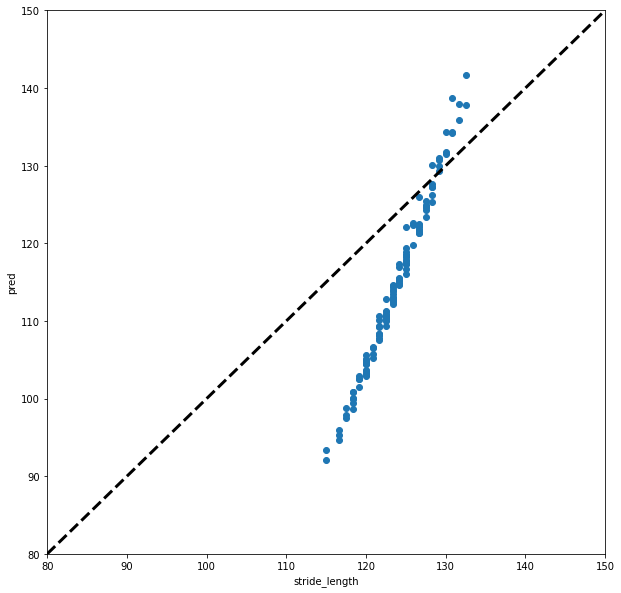

In [7]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([80, 10])
plt.xlabel('stride_length')
plt.ylim([80, 150])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## 4km

In [160]:
file_path_train = "D:\gait_dataset/salted/4km/train/*"
_, _, y_train = get_sensor_salted(file_path_train)
inputs_pst_train = get_position_salted(file_path_train, distance=True)

file_path_test = "D:\gait_dataset/salted/4km/test/*"
_, _, y_test = get_sensor_salted(file_path_test)
inputs_pst_test = get_position_salted(file_path_test, distance=True)

In [161]:
x_train = pd.DataFrame(inputs_pst_train)
x_train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

x_test = pd.DataFrame(inputs_pst_test)
x_test.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

In [162]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [163]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

12.419413178967062

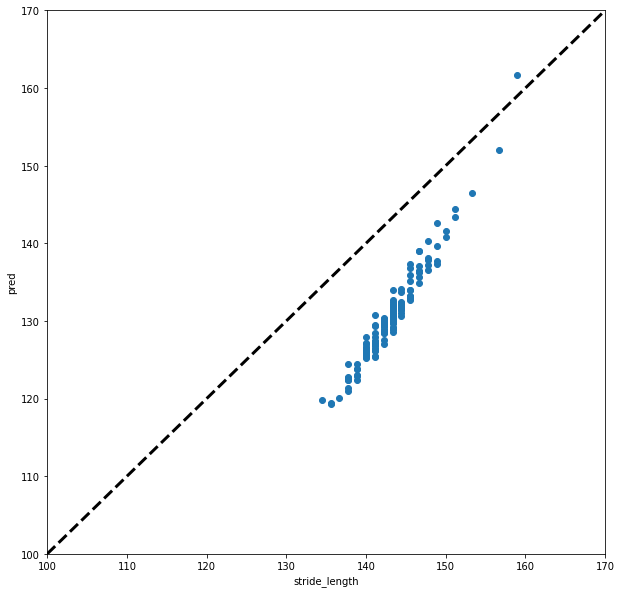

In [164]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([100, 170])
plt.xlabel('stride_length')
plt.ylim([100, 170])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## 5km

In [165]:
file_path_train = "D:\gait_dataset/salted/5km/train/*"
_, _, y_train = get_sensor_salted(file_path_train)
inputs_pst_train = get_position_salted(file_path_train, distance=True)

file_path_test = "D:\gait_dataset/salted/5km/test/*"
_, _, y_test = get_sensor_salted(file_path_test)
inputs_pst_test = get_position_salted(file_path_test, distance=True)

In [166]:
x_train = pd.DataFrame(inputs_pst_train)
x_train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

x_test = pd.DataFrame(inputs_pst_test)
x_test.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

In [167]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [168]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

21.65589277120109

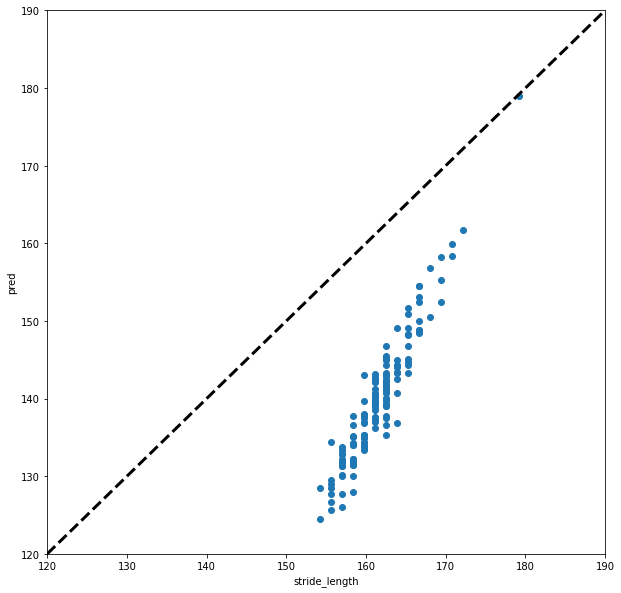

In [171]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([120, 190])
plt.xlabel('stride_length')
plt.ylim([120, 190])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : 최종 노드 1개
- 3km에서 kernel_size 조정(30 -> 60)을 해보았는데 효과가 없어 이후 속도에는 kernel_size를 30으로 통일
- 속도별 MAE는 2.524 / 2.523 / 2.62로 선형 회귀에 비해 속도가 올라가더라도 MAE가 안정적

## 3km

### 데이터 불러오기

In [74]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/3km/train/*"
dataset = Gait_Dataset_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [75]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1
- Best Result : Epoch 212, Valid Loss 13.249361, MAE 2.524274

In [100]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [101]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [84]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_1_best_ks30_spd3.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 10939.895578, Valid Loss 3632.013550, MAE 59.925022
Epoch : 2/2000, Train Loss : 1798.283920, Valid Loss 1801.878662, MAE 41.865826
Epoch : 3/2000, Train Loss : 1112.495275, Valid Loss 768.434296, MAE 26.482611
Best Valid Loss 768.4343
Epoch : 4/2000, Train Loss : 502.936486, Valid Loss 569.153656, MAE 22.718924
Best Valid Loss 569.1537
Epoch : 5/2000, Train Loss : 287.144473, Valid Loss 247.071388, MAE 13.850640
Best Valid Loss 247.0714
Epoch : 6/2000, Train Loss : 152.573884, Valid Loss 119.580856, MAE 8.482688
Best Valid Loss 119.5809
Epoch : 7/2000, Train Loss : 97.531525, Valid Loss 57.765516, MAE 6.023322
Best Valid Loss 57.7655
Epoch : 8/2000, Train Loss : 80.501342, Valid Loss 68.930901, MAE 6.971463
Epoch : 9/2000, Train Loss : 66.350633, Valid Loss 78.679192, MAE 6.371610
Epoch : 10/2000, Train Loss : 63.803889, Valid Loss 57.078882, MAE 6.349782
Best Valid Loss 57.0789
Epoch : 11/2000, Train Loss : 57.286502, Valid Loss 55.050852, MAE 5.799289
Be

Epoch : 95/2000, Train Loss : 19.140078, Valid Loss 19.450746, MAE 2.933224
Epoch : 96/2000, Train Loss : 18.285633, Valid Loss 18.408744, MAE 2.710371
Best Valid Loss 18.4087
Epoch : 97/2000, Train Loss : 18.813673, Valid Loss 20.265720, MAE 2.838463
Epoch : 98/2000, Train Loss : 19.631288, Valid Loss 18.676198, MAE 2.597996
Epoch : 99/2000, Train Loss : 19.972845, Valid Loss 18.645838, MAE 2.767682
Epoch : 100/2000, Train Loss : 17.598719, Valid Loss 17.992649, MAE 2.592889
Best Valid Loss 17.9926
Epoch : 101/2000, Train Loss : 17.257439, Valid Loss 18.246986, MAE 2.673612
Epoch : 102/2000, Train Loss : 17.518410, Valid Loss 17.939549, MAE 2.562438
Best Valid Loss 17.9395
Epoch : 103/2000, Train Loss : 19.593777, Valid Loss 23.748397, MAE 3.359247
Epoch : 104/2000, Train Loss : 18.749134, Valid Loss 17.896902, MAE 2.550804
Best Valid Loss 17.8969
Epoch : 105/2000, Train Loss : 17.408270, Valid Loss 17.520284, MAE 2.548951
Best Valid Loss 17.5203
Epoch : 106/2000, Train Loss : 17.4057

Epoch : 197/2000, Train Loss : 11.087150, Valid Loss 14.286655, MAE 2.562585
Epoch : 198/2000, Train Loss : 8.632165, Valid Loss 22.617235, MAE 3.801951
Epoch : 199/2000, Train Loss : 14.680963, Valid Loss 22.748958, MAE 3.821693
Epoch : 200/2000, Train Loss : 13.960383, Valid Loss 14.587504, MAE 2.616297
Epoch : 201/2000, Train Loss : 14.321797, Valid Loss 19.026140, MAE 3.258844
Epoch : 202/2000, Train Loss : 12.754327, Valid Loss 41.172112, MAE 5.593235
Epoch : 203/2000, Train Loss : 21.846250, Valid Loss 64.307373, MAE 7.339233
Epoch : 204/2000, Train Loss : 27.228176, Valid Loss 30.074167, MAE 4.591873
Epoch : 205/2000, Train Loss : 15.820258, Valid Loss 35.295496, MAE 5.113158
Epoch : 206/2000, Train Loss : 21.053114, Valid Loss 49.358086, MAE 6.257267
Epoch : 207/2000, Train Loss : 22.942453, Valid Loss 29.619387, MAE 4.492602
Epoch : 208/2000, Train Loss : 16.652437, Valid Loss 39.357729, MAE 5.454469
Epoch : 209/2000, Train Loss : 14.958501, Valid Loss 20.622001, MAE 3.506372


In [102]:
### scatter plot
file_path = "D:\gait_dataset/salted/3km/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [103]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_1_best_ks30_spd3.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

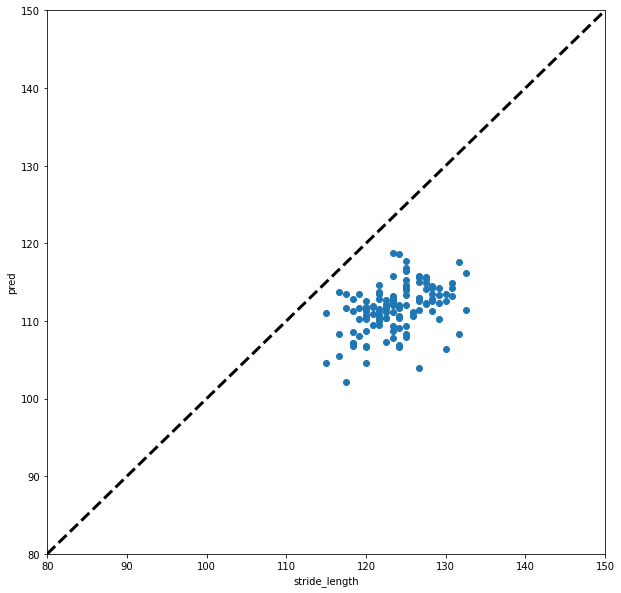

In [104]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 150])
plt.xlabel('stride_length')
plt.ylim([80, 150])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- Conv1d의 kernel_size 조정 : 30 -> 60
- Best Result : Epoch 247, Valid Loss 18.055473, MAE 2.682558
    - 큰 영향이 없어보임

## 4km

### 데이터 불러오기

In [139]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/4km/train/*"
dataset = Gait_Dataset_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [140]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1
- Best Result : Epoch 269, Valid Loss 10.721025, MAE 2.522949

In [141]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [142]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [143]:
#Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_1_best_ks30_spd4.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 15534.720703, Valid Loss 7607.407227, MAE 86.870811
Epoch : 2/2000, Train Loss : 2900.762168, Valid Loss 1838.525391, MAE 42.195084
Epoch : 3/2000, Train Loss : 1781.224357, Valid Loss 212.594772, MAE 12.468178
Best Valid Loss 212.5948
Epoch : 4/2000, Train Loss : 627.974509, Valid Loss 680.781494, MAE 24.814661
Epoch : 5/2000, Train Loss : 422.626349, Valid Loss 339.368774, MAE 16.234888
Epoch : 6/2000, Train Loss : 235.676060, Valid Loss 303.113693, MAE 15.387850
Epoch : 7/2000, Train Loss : 150.152499, Valid Loss 110.632973, MAE 9.196754
Best Valid Loss 110.6330
Epoch : 8/2000, Train Loss : 100.304974, Valid Loss 78.771603, MAE 7.237212
Best Valid Loss 78.7716
Epoch : 9/2000, Train Loss : 80.500293, Valid Loss 89.130272, MAE 7.498062
Epoch : 10/2000, Train Loss : 71.275701, Valid Loss 68.353657, MAE 7.386012
Best Valid Loss 68.3537
Epoch : 11/2000, Train Loss : 64.058186, Valid Loss 64.918003, MAE 7.087172
Best Valid Loss 64.9180
Epoch : 12/2000, Train L

Epoch : 93/2000, Train Loss : 11.427637, Valid Loss 13.832630, MAE 2.947352
Epoch : 94/2000, Train Loss : 12.865714, Valid Loss 16.488848, MAE 3.399729
Epoch : 95/2000, Train Loss : 13.855063, Valid Loss 14.593515, MAE 2.881090
Epoch : 96/2000, Train Loss : 14.691280, Valid Loss 20.243589, MAE 3.421180
Epoch : 97/2000, Train Loss : 12.357458, Valid Loss 16.908981, MAE 3.456102
Epoch : 98/2000, Train Loss : 14.439103, Valid Loss 16.057406, MAE 3.340631
Epoch : 99/2000, Train Loss : 13.896231, Valid Loss 17.144254, MAE 3.113321
Epoch : 100/2000, Train Loss : 13.600437, Valid Loss 14.000295, MAE 2.858269
Epoch : 101/2000, Train Loss : 14.736774, Valid Loss 19.002533, MAE 3.702288
Epoch : 102/2000, Train Loss : 16.051042, Valid Loss 13.617118, MAE 2.855685
Best Valid Loss 13.6171
Epoch : 103/2000, Train Loss : 12.631957, Valid Loss 15.431073, MAE 2.949553
Epoch : 104/2000, Train Loss : 12.897871, Valid Loss 13.759264, MAE 2.961655
Epoch : 105/2000, Train Loss : 12.297177, Valid Loss 13.537

Best Valid Loss 11.8371
Epoch : 194/2000, Train Loss : 10.237718, Valid Loss 25.415874, MAE 4.026493
Epoch : 195/2000, Train Loss : 16.026172, Valid Loss 11.899245, MAE 2.643956
Epoch : 196/2000, Train Loss : 15.214777, Valid Loss 15.128815, MAE 3.165537
Epoch : 197/2000, Train Loss : 12.066716, Valid Loss 13.793606, MAE 3.003152
Epoch : 198/2000, Train Loss : 10.153116, Valid Loss 13.250397, MAE 2.776765
Epoch : 199/2000, Train Loss : 11.588071, Valid Loss 19.216828, MAE 3.400829
Epoch : 200/2000, Train Loss : 16.312756, Valid Loss 13.503139, MAE 2.788875
Epoch : 201/2000, Train Loss : 18.186712, Valid Loss 14.737943, MAE 3.147207
Epoch : 202/2000, Train Loss : 10.441097, Valid Loss 12.616116, MAE 2.853876
Epoch : 203/2000, Train Loss : 11.233278, Valid Loss 11.608939, MAE 2.637326
Best Valid Loss 11.6089
Epoch : 204/2000, Train Loss : 10.335904, Valid Loss 11.643191, MAE 2.646629
Epoch : 205/2000, Train Loss : 11.581287, Valid Loss 16.510141, MAE 3.320710
Epoch : 206/2000, Train Loss

In [172]:
### scatter plot
file_path = "D:\gait_dataset/salted/4km/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [173]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_1_best_ks30_spd4.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

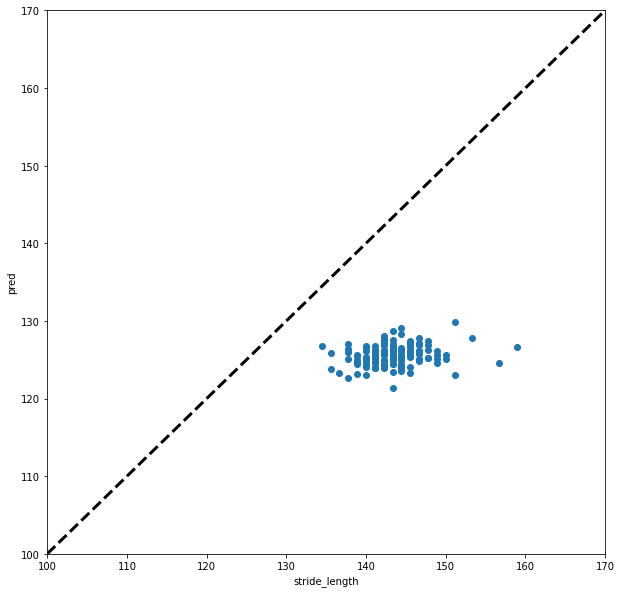

In [174]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([100, 170])
plt.xlabel('stride_length')
plt.ylim([100, 170])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## 5km

### 데이터 불러오기

In [125]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/5km/train/*"
dataset = Gait_Dataset_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [126]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1
- Best Result : Epoch 167, Valid Loss 12.062933, MAE 2.615243

In [130]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [131]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [132]:
#Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_1_best_ks30_spd5.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 18758.116821, Valid Loss 4744.157715, MAE 69.445648
Epoch : 2/2000, Train Loss : 2935.094131, Valid Loss 3597.040649, MAE 60.468773
Epoch : 3/2000, Train Loss : 1767.340346, Valid Loss 1681.194275, MAE 38.442814
Epoch : 4/2000, Train Loss : 768.939221, Valid Loss 574.662201, MAE 23.464323
Best Valid Loss 574.6622
Epoch : 5/2000, Train Loss : 339.524832, Valid Loss 99.902805, MAE 8.395190
Best Valid Loss 99.9028
Epoch : 6/2000, Train Loss : 192.520610, Valid Loss 164.517609, MAE 9.050871
Epoch : 7/2000, Train Loss : 139.953060, Valid Loss 147.809822, MAE 11.114594
Epoch : 8/2000, Train Loss : 102.613956, Valid Loss 82.432835, MAE 6.895371
Best Valid Loss 82.4328
Epoch : 9/2000, Train Loss : 89.221479, Valid Loss 87.081238, MAE 6.628442
Epoch : 10/2000, Train Loss : 87.534990, Valid Loss 82.576252, MAE 7.281987
Epoch : 11/2000, Train Loss : 83.518036, Valid Loss 92.790348, MAE 8.195049
Epoch : 12/2000, Train Loss : 84.274821, Valid Loss 76.458405, MAE 6.77288

Epoch : 93/2000, Train Loss : 13.665192, Valid Loss 15.661646, MAE 2.957166
Epoch : 94/2000, Train Loss : 13.899644, Valid Loss 14.751303, MAE 2.954451
Best Valid Loss 14.7513
Epoch : 95/2000, Train Loss : 16.850653, Valid Loss 17.095434, MAE 3.285758
Epoch : 96/2000, Train Loss : 14.919902, Valid Loss 16.637392, MAE 3.221945
Epoch : 97/2000, Train Loss : 13.184323, Valid Loss 14.476883, MAE 2.912561
Best Valid Loss 14.4769
Epoch : 98/2000, Train Loss : 13.428752, Valid Loss 24.979079, MAE 4.238469
Epoch : 99/2000, Train Loss : 16.150081, Valid Loss 17.480402, MAE 3.324299
Epoch : 100/2000, Train Loss : 14.199055, Valid Loss 14.414844, MAE 2.880261
Best Valid Loss 14.4148
Epoch : 101/2000, Train Loss : 13.166050, Valid Loss 15.552437, MAE 2.939806
Epoch : 102/2000, Train Loss : 13.058767, Valid Loss 14.004888, MAE 2.858818
Best Valid Loss 14.0049
Epoch : 103/2000, Train Loss : 13.881631, Valid Loss 16.681405, MAE 3.264049
Epoch : 104/2000, Train Loss : 13.037243, Valid Loss 13.942929, 

In [175]:
### scatter plot
file_path = "D:\gait_dataset/salted/5km/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [176]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_1_best_ks30_spd5.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

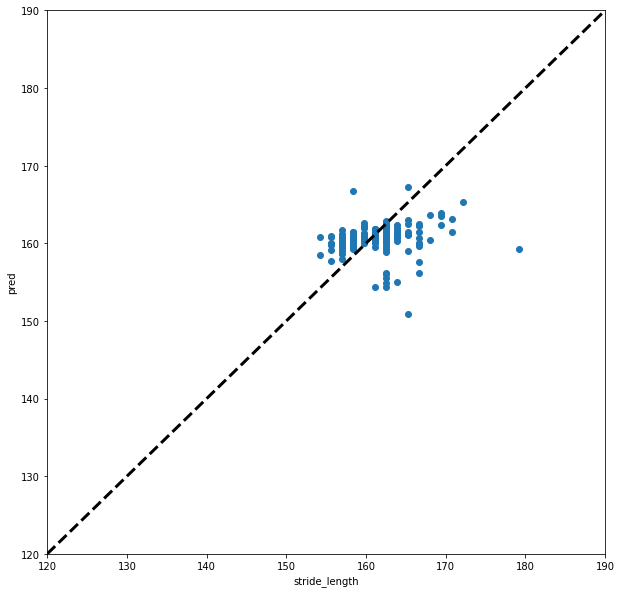

In [177]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([120, 190])
plt.xlabel('stride_length')
plt.ylim([120, 190])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : Acc, Gyro 각각 입력, 최종 노드 3개
- 최종적으로 출력된 노드 3개를 각 축별 distance와 곱

## 3km

### 데이터 불러오기

In [147]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/3km/train/*"
dataset = Gait_Dataset_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [148]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

## Model & Scatter Plot
- Best Result : Epoch 202, Valid Loss 91.219509, MAE 7.251199

In [149]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder_dist(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_dist, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [150]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [151]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)

        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_dist_best_ks30_spd3.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 11398.500419, Valid Loss 5348.666992, MAE 72.497993
Epoch : 2/2000, Train Loss : 2827.603376, Valid Loss 2193.217163, MAE 43.246780
Epoch : 3/2000, Train Loss : 2041.373029, Valid Loss 1246.975403, MAE 28.785944
Epoch : 4/2000, Train Loss : 1376.399894, Valid Loss 1233.407104, MAE 29.382618
Epoch : 5/2000, Train Loss : 1116.495658, Valid Loss 1048.000793, MAE 26.885494
Epoch : 6/2000, Train Loss : 1030.286778, Valid Loss 859.470673, MAE 24.889471
Best Valid Loss 859.4707
Epoch : 7/2000, Train Loss : 936.449079, Valid Loss 782.332947, MAE 24.173378
Best Valid Loss 782.3329
Epoch : 8/2000, Train Loss : 920.324794, Valid Loss 756.152161, MAE 23.741966
Best Valid Loss 756.1522
Epoch : 9/2000, Train Loss : 836.564331, Valid Loss 743.851807, MAE 23.461235
Best Valid Loss 743.8518
Epoch : 10/2000, Train Loss : 848.574323, Valid Loss 709.074341, MAE 22.888334
Best Valid Loss 709.0743
Epoch : 11/2000, Train Loss : 823.718567, Valid Loss 715.484802, MAE 22.465973
Epo

Best Valid Loss 206.0146
Epoch : 94/2000, Train Loss : 276.321542, Valid Loss 202.293404, MAE 11.515812
Best Valid Loss 202.2934
Epoch : 95/2000, Train Loss : 253.704008, Valid Loss 207.285988, MAE 12.046765
Epoch : 96/2000, Train Loss : 262.293016, Valid Loss 195.743187, MAE 11.479960
Best Valid Loss 195.7432
Epoch : 97/2000, Train Loss : 310.197324, Valid Loss 226.584579, MAE 12.269913
Epoch : 98/2000, Train Loss : 272.577264, Valid Loss 204.344681, MAE 11.943614
Epoch : 99/2000, Train Loss : 279.416848, Valid Loss 211.271797, MAE 11.854234
Epoch : 100/2000, Train Loss : 281.268088, Valid Loss 318.748642, MAE 15.182103
Epoch : 101/2000, Train Loss : 286.827325, Valid Loss 190.081497, MAE 11.287629
Best Valid Loss 190.0815
Epoch : 102/2000, Train Loss : 271.352179, Valid Loss 266.160065, MAE 14.004783
Epoch : 103/2000, Train Loss : 288.257398, Valid Loss 241.878036, MAE 12.897334
Epoch : 104/2000, Train Loss : 286.849291, Valid Loss 193.187889, MAE 11.546453
Epoch : 105/2000, Train Lo

Epoch : 191/2000, Train Loss : 111.506693, Valid Loss 107.872131, MAE 8.008227
Epoch : 192/2000, Train Loss : 113.118461, Valid Loss 102.950825, MAE 7.702386
Epoch : 193/2000, Train Loss : 132.231607, Valid Loss 113.417473, MAE 8.380519
Epoch : 194/2000, Train Loss : 120.956873, Valid Loss 163.721268, MAE 10.782781
Epoch : 195/2000, Train Loss : 144.741515, Valid Loss 99.050938, MAE 7.700439
Best Valid Loss 99.0509
Epoch : 196/2000, Train Loss : 106.933082, Valid Loss 97.763184, MAE 7.661909
Best Valid Loss 97.7632
Epoch : 197/2000, Train Loss : 113.418921, Valid Loss 93.158264, MAE 7.405396
Best Valid Loss 93.1583
Epoch : 198/2000, Train Loss : 106.642004, Valid Loss 115.226582, MAE 8.398019
Epoch : 199/2000, Train Loss : 138.521889, Valid Loss 174.571999, MAE 11.337372
Epoch : 200/2000, Train Loss : 153.532193, Valid Loss 120.865887, MAE 8.641755
Epoch : 201/2000, Train Loss : 119.635233, Valid Loss 141.979488, MAE 9.696430
Epoch : 202/2000, Train Loss : 117.832719, Valid Loss 91.219

In [152]:
# scatter plot

file_path = "D:\gait_dataset/salted/3km/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

In [153]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_dist_best_ks30_spd3.pth'))
model.eval()

Encoder_dist(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

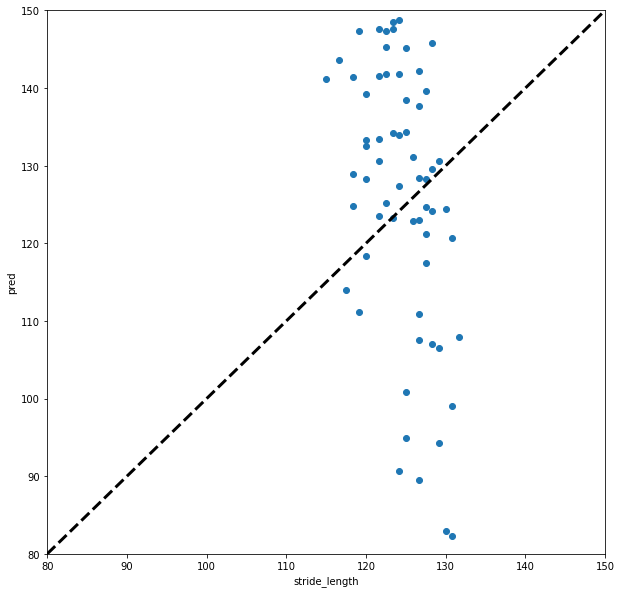

In [154]:
pred = model(inputs_acc, inputs_gyr)
pred = torch.unsqueeze(torch.sum(pred*inputs_pst, axis=1), 1).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 150])
plt.xlabel('stride_length')
plt.ylim([80, 150])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : Acc, Gyro 축별 입력
- 각 축 Acc에서 얻어진 축별 distance를 곱해주기 때문에 축별로 데이터를 입력
    - 축별 Acc/Gyro의 정보가 알맞은 축의 distance와 곱해져야 한다는 생각에 시도
- 3개의 인코더에는 각각 (Acc_x, Gyro_x) / (Acc_y, Gyro_y) / (Acc_z, Gyro_z)가 입력으로 들어감
    - 인코더의 각 output을 concat한 뒤 FC-Layer에 넣었을 때, 축별 정보가 순서대로 보존될 수 있을지는 의문 부호 
- Pressure는 축이 따로 없으므로 고려하지 않음

## 데이터 불러오기

In [45]:
file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Axis_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [46]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

## Model & Scatter Plot
- Best Result : Epoch 194, Valid Loss 32.528639, MAE 4.294555

In [70]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder_axis(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_axis, self).__init__()
             
        self.conv1d_x = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_y = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        
        self.conv1d_z = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*3, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        

    def forward(self, inputs_x, inputs_y, inputs_z): 
        conv1d_output_x = self.conv1d_x(inputs_x)
        conv1d_output_y = self.conv1d_y(inputs_y)
        conv1d_output_z = self.conv1d_z(inputs_z)
        
        enc_output = torch.concat((conv1d_output_x, conv1d_output_y, conv1d_output_z), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [71]:
input_dim = 2
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [72]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
        inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_x, inputs_y, inputs_z)
        outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)

        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
            inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_x, inputs_y, inputs_z)
            outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_axis_best_ks30.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 6849.530436, Valid Loss 1168.314697, MAE 31.355806
Epoch : 2/2000, Train Loss : 864.669326, Valid Loss 612.329783, MAE 16.264860
Best Valid Loss 612.3298
Epoch : 3/2000, Train Loss : 589.246938, Valid Loss 526.594884, MAE 18.518312
Best Valid Loss 526.5949
Epoch : 4/2000, Train Loss : 553.286203, Valid Loss 512.176890, MAE 18.732841
Best Valid Loss 512.1769
Epoch : 5/2000, Train Loss : 548.926233, Valid Loss 526.086319, MAE 20.278049
Epoch : 6/2000, Train Loss : 511.977479, Valid Loss 473.860921, MAE 17.935377
Best Valid Loss 473.8609
Epoch : 7/2000, Train Loss : 489.095901, Valid Loss 448.458491, MAE 17.434975
Best Valid Loss 448.4585
Epoch : 8/2000, Train Loss : 473.027990, Valid Loss 432.769114, MAE 16.332811
Best Valid Loss 432.7691
Epoch : 9/2000, Train Loss : 444.482322, Valid Loss 412.248550, MAE 15.951297
Best Valid Loss 412.2486
Epoch : 10/2000, Train Loss : 414.985577, Valid Loss 397.752101, MAE 17.163071
Best Valid Loss 397.7521
Epoch : 11/2000, 

Epoch : 94/2000, Train Loss : 60.780403, Valid Loss 76.036847, MAE 7.179021
Epoch : 95/2000, Train Loss : 67.996763, Valid Loss 79.636118, MAE 7.578677
Epoch : 96/2000, Train Loss : 65.629438, Valid Loss 88.479898, MAE 7.678430
Epoch : 97/2000, Train Loss : 58.668947, Valid Loss 74.371758, MAE 7.172230
Best Valid Loss 74.3718
Epoch : 98/2000, Train Loss : 57.906890, Valid Loss 76.306203, MAE 6.679660
Epoch : 99/2000, Train Loss : 64.026802, Valid Loss 80.587857, MAE 7.149890
Epoch : 100/2000, Train Loss : 61.044780, Valid Loss 85.293031, MAE 8.288418
Epoch : 101/2000, Train Loss : 70.472009, Valid Loss 100.799805, MAE 8.421721
Epoch : 102/2000, Train Loss : 81.524724, Valid Loss 93.171730, MAE 8.748089
Epoch : 103/2000, Train Loss : 59.431019, Valid Loss 68.915815, MAE 6.823329
Best Valid Loss 68.9158
Epoch : 104/2000, Train Loss : 54.576843, Valid Loss 68.180007, MAE 6.618252
Best Valid Loss 68.1800
Epoch : 105/2000, Train Loss : 52.746727, Valid Loss 76.125436, MAE 7.439564
Epoch : 1

Epoch : 193/2000, Train Loss : 26.176221, Valid Loss 42.891813, MAE 5.180143
Epoch : 194/2000, Train Loss : 24.221730, Valid Loss 32.528639, MAE 4.294555
Best Valid Loss 32.5286
Epoch : 195/2000, Train Loss : 25.207433, Valid Loss 35.785869, MAE 4.636862
Epoch : 196/2000, Train Loss : 26.416232, Valid Loss 37.128935, MAE 4.997412
Epoch : 197/2000, Train Loss : 23.993095, Valid Loss 41.893327, MAE 4.866847
Epoch : 198/2000, Train Loss : 23.133130, Valid Loss 33.576603, MAE 4.333020
Epoch : 199/2000, Train Loss : 25.393146, Valid Loss 47.359198, MAE 5.171652
Epoch : 200/2000, Train Loss : 35.671273, Valid Loss 45.330066, MAE 5.152297
Epoch : 201/2000, Train Loss : 26.471109, Valid Loss 36.986179, MAE 4.440410
Epoch : 202/2000, Train Loss : 26.766417, Valid Loss 41.681213, MAE 4.886549
Epoch : 203/2000, Train Loss : 35.939796, Valid Loss 49.900145, MAE 5.942390
Epoch : 204/2000, Train Loss : 25.655564, Valid Loss 44.643739, MAE 5.367122
Epoch : 205/2000, Train Loss : 34.139870, Valid Loss

In [73]:
### scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_x, inputs_y, inputs_z, stride_length = get_axis_sensor_salted(file_path)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = torch.Tensor(np.array(inputs_x)), torch.Tensor(np.array(inputs_y)), torch.Tensor(np.array(inputs_z)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)

# stride_length = stride_length.reshape(-1, 1)
# stride_length = stride_length.to(device)

In [76]:
input_dim = 2
hidden_dim1 = 16
hidden_dim2 = 32
lstm_hidden = 64

model = Encoder_axis(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./encoder_axis_best_ks30.pth'))
model.eval()

Encoder_axis(
  (conv1d_x): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_y): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_z): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=23232, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
  

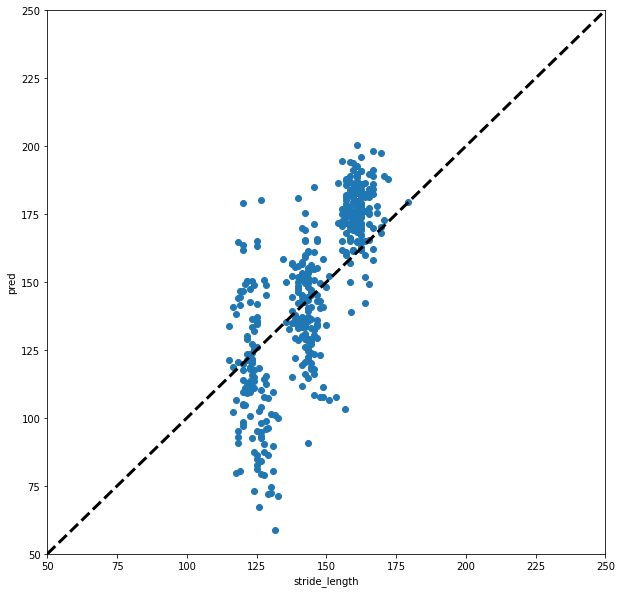

In [77]:
pred = model(inputs_x, inputs_y, inputs_z)
pred = torch.unsqueeze(torch.sum(pred*inputs_pst, axis=1), 1).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()